# Part 1. Using Pyspark to connect to the database

In [1]:
from pyspark.sql import SparkSession
import warnings

warnings.filterwarnings("ignore")

# Create a SparkSession
spark = (
    SparkSession.builder.appName("Bugzilla")
    .config("spark.driver.extraClassPath", "postgresql-42.6.0.jar")
    .config("spark.driver.memory", "24g")
    .getOrCreate()
)

# Define the connection properties
url = "jdbc:postgresql://localhost/bugzilla"
properties = {"user": "postgres", "password": "123456"}

# Read data from the PostgreSQL database into a DataFrame
reports = spark.read.jdbc(url=url, table="reports", properties=properties)
custom_fields = spark.read.jdbc(url=url, table="custom_fields", properties=properties)
comments = spark.read.jdbc(url=url, table="comments", properties=properties)

# Perform operations on the DataFrame
reports.show()

your 131072x1 screen size is bogus. expect trouble
23/07/18 00:01:51 WARN Utils: Your hostname, AlienwareR8 resolves to a loopback address: 127.0.1.1; using 172.23.245.11 instead (on interface eth0)
23/07/18 00:01:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/18 00:01:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/07/18 00:01:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-----+--------------------+--------------+--------------------+--------------------+--------------------+---------------+-------------+--------------------+-------------------+--------------------+----------+--------------+-------+--------------+------+----------------+------------+---------------------+-------+--------------------+-------------------+-------+----------+--------------+--------+--------+--------------------+--------------------+-------------+------------+-----------+----------+--------+--------+--------+--------------------+----------------+------+--------------------+--------------------+-----------+-----+--------------------+
|bug_id|alias|         assigned_to|assigned_to_id|              blocks|                  cc|               cc_id| classification|comment_count|           component|      creation_time|             creator|creator_id|    depends_on|dupe_of|    duplicates|groups|is_cc_accessible|is_confirmed|is_creator_accessible|is_open|            keyword

# Part 2. Network Analysis with Pyspark
**Bug Interaction Network**: A network based on how bugs interact with each other. For example, if a bug has been marked as a duplicate of another, we could create an edge between those two bugs. Similarly, we could link bugs that are depended on by other bugs. After the network is created, we could use network analysis techniques to calculate their centrality measures and see if they are contributes to the resolving time of each bug.

In [2]:
import networkx as nx
from tqdm.notebook import tqdm
from pyspark.sql.functions import col

In [3]:
# Select the required columns from the reports DataFrame
reports_select = reports.select(
    "bug_id", "depends_on", "dupe_of", "blocks", "duplicates", "creation_time", "status"
)

# Collect the data as a list of Rows
rows = reports_select.collect()

# Initialize an empty list to store the dependency data
all_dependency = []

# Iterate over the collected Rows
for row in tqdm(rows):
    # Extract the values from the Row
    bug_id = row.bug_id
    depend_on = row.depends_on
    dupe_of = row.dupe_of
    blocks = row.blocks
    duplicates = row.duplicates
    creation_time = row.creation_time
    status = row.status

    # Append the data to the list
    all_dependency.append(
        {
            "bug_id": bug_id,
            "depend_on": depend_on,
            "dupe_of": dupe_of,
            "blocks": blocks,
            "duplicates": duplicates,
            "creation_time": creation_time,
            "status": status,
        }
    )

# Create a PySpark DataFrame from the list
bug_int_df = spark.createDataFrame(all_dependency)

# Show the DataFrame
bug_int_df.show()

  0%|          | 0/213313 [00:00<?, ?it/s]

23/07/17 23:22:36 WARN TaskSetManager: Stage 2 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------+-------------------+--------------+-------+--------------+--------+
|              blocks|bug_id|      creation_time|     depend_on|dupe_of|    duplicates|  status|
+--------------------+------+-------------------+--------------+-------+--------------+--------+
|                  []|138920|2002-04-21 04:56:13|            []|      0|            []|VERIFIED|
|                  []|205714|2003-05-14 20:11:03|            []| 243074|            []|RESOLVED|
|                  []|212510|2003-07-12 14:17:22|            []|      0|            []|RESOLVED|
|                  []| 18380|1999-11-10 00:03:33|            []|   7404|            []|VERIFIED|
|                  []|124111|2002-02-07 10:30:06|            []|      0|            []|VERIFIED|
|             [16950]| 16258|1999-10-13 02:48:55|       [16578]|      0|            []|VERIFIED|
|                  []| 94961|2001-08-12 12:08:01|            []|      0|            []|VERIFIED|
|                  []|159194|2

## 2.1 Duplication Network

In [4]:
# Create a duplication network using networkx
dup_g = nx.DiGraph()

# Add the edges to the graph
dup_edges = bug_int_df.select(
    col("bug_id").alias("source"), col("duplicates").alias("target")
).distinct()

dupe_of_edges = bug_int_df.select(
    col("bug_id").alias("source"), col("dupe_of").alias("target")
).distinct()


# List to store the edges
dup_edges_list = [
    ("bug_id:" + str(source), "bug_id:" + str(target_id))
    for source, target in dup_edges.collect()
    for target_id in target
] + (
    [
        ("bug_id:" + str(source), "bug_id:" + str(target_id))
        for source, target_id in dupe_of_edges.collect()
        if target_id != 0
    ]
)


# Add the edges to the graph
dup_g.add_edges_from(dup_edges_list)
print(
    f"Number of nodes: {dup_g.number_of_nodes()}, Number of edges: {dup_g.number_of_edges()}"
)

# Calculate the In-Degree Centrality
dup_in_degree = nx.in_degree_centrality(dup_g)
# dup_in_degree = dup_g.in_degree()
dup_in_degree_id = [int(bug_id.split(":")[1]) for bug_id in dup_in_degree.keys()]

# Create a dictionary of bug_id and in_degree
dup_in_degree = dict(zip(dup_in_degree_id, dup_in_degree.values()))

# Create a PySpark DataFrame from the dictionary
dup_in_degree_df = spark.createDataFrame(
    dup_in_degree.items(), ["bug_id", "dup_in_degree"]
)

# Merge the in_degree values with the bug_int_df DataFrame
bug_int_df = bug_int_df.join(dup_in_degree_df, on="bug_id", how="left")

# Show the DataFrame
bug_int_df.show()

23/07/17 23:22:37 WARN TaskSetManager: Stage 3 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.
23/07/17 23:22:40 WARN TaskSetManager: Stage 6 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


Number of nodes: 113457, Number of edges: 154705


23/07/17 23:22:42 WARN TaskSetManager: Stage 9 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+------+--------------------+-------------------+--------------+-------+--------------+--------+--------------------+
|bug_id|              blocks|      creation_time|     depend_on|dupe_of|    duplicates|  status|       dup_in_degree|
+------+--------------------+-------------------+--------------+-------+--------------+--------+--------------------+
|196839|                  []|2003-03-11 10:22:13|            []| 381472|            []|RESOLVED|                 0.0|
| 58001|                  []|2000-10-25 23:35:17|            []|      0|            []|VERIFIED|                null|
|113894|[97141, 97143, 97...|2001-12-06 21:55:36|[36972, 78013]|      0|            []|RESOLVED|                null|
|119167|                  []|2002-01-10 13:47:47|      [163923]|      0|            []|RESOLVED|                null|
| 39039|                  []|2000-05-12 09:14:55|            []|      0|            []|RESOLVED|                null|
|138937|                  []|2002-04-21 07:40:19|       

As the network is very large, if we want to visualise the network, we need to write a function to extract the subgraph of the network. The function is as follows:

In [5]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


def plot_subgraph(g, title, num_of_nodes=100):
    # Select the top n nodes with the highest in-degree
    top_nodes = sorted(g.in_degree(), key=lambda x: x[1], reverse=True)[:num_of_nodes]

    # Create a set to store the nodes in the subgraph
    subgraph_nodes = set()

    # Add the top nodes to the subgraph
    for node, _ in top_nodes:
        subgraph_nodes.add(node)

    # Add all the connected nodes to the subgraph
    for node in top_nodes:
        subgraph_nodes.update(g.predecessors(node[0]))

    # Create a subgraph from the nodes
    sub_g = g.subgraph(subgraph_nodes)

    fig = plt.figure(figsize=(16, 10))
    # arrange the figure around a grid
    gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[2, 1], height_ratios=[1, 1])
    # the plots
    ax0 = plt.subplot(gs[0:2, 0])
    ax0.set_title(title, fontsize=20)
    ax1 = plt.subplot(gs[0, 1])
    ax1.set_title("Network Signature", fontsize=20)
    ax2 = plt.subplot(gs[1, 1])
    ax2.set_title("Degree Distribution", fontsize=20)
    # draw the network
    ax0.set_facecolor("black")
    pos = nx.spring_layout(sub_g)
    options = {
        "node_color": "white",
        "alpha": 0.5,
        "node_size": 4,
        "width": 0.2,
        "edge_color": "white",
        "with_labels": False,
    }
    nx.draw_networkx(sub_g, pos=pos, ax=ax0, **options)

    # information about the network
    ax1.axis("off")
    if nx.is_directed(sub_g):
        ax1.text(
            0.05,
            0.95,
            "Directed: {}".format(nx.is_directed(sub_g)),
            fontsize=16,
            verticalalignment="top",
        )
        ax1.text(
            0.05,
            0.75,
            f"Number of nodes: {g.number_of_nodes()}, Number of edges: {g.number_of_edges()}",
            fontsize=16,
            verticalalignment="top",
        )
    else:
        ax1.text(
            0.05,
            0.95,
            "Connected: {}".format(nx.is_connected(sub_g)),
            fontsize=16,
            verticalalignment="top",
        )
        ax1.text(
            0.05,
            0.75,
            "Connected comps: {}".format(nx.number_connected_components(sub_g)),
            fontsize=16,
            verticalalignment="top",
        )
    nd = [v for k, v in sub_g.degree()]
    k = np.mean(nd)
    dd = Counter(nd)
    ave_cl = nx.average_clustering(sub_g)
    ax1.text(
        0.05, 0.55, "Ave. degree: {}".format(k), fontsize=16, verticalalignment="top"
    )
    ax1.text(
        0.05,
        0.35,
        "Ave. clustering: {}".format(np.round(ave_cl, 2)),
        fontsize=16,
        verticalalignment="top",
    )
    # draw the degree distribution
    ax2.scatter(dd.keys(), dd.values(), color="k", alpha=0.5, s=6)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_xlabel("log(k)", fontsize=12)
    ax2.set_ylabel("log(p(k))", fontsize=12)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    # spacing
    plt.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None
    )

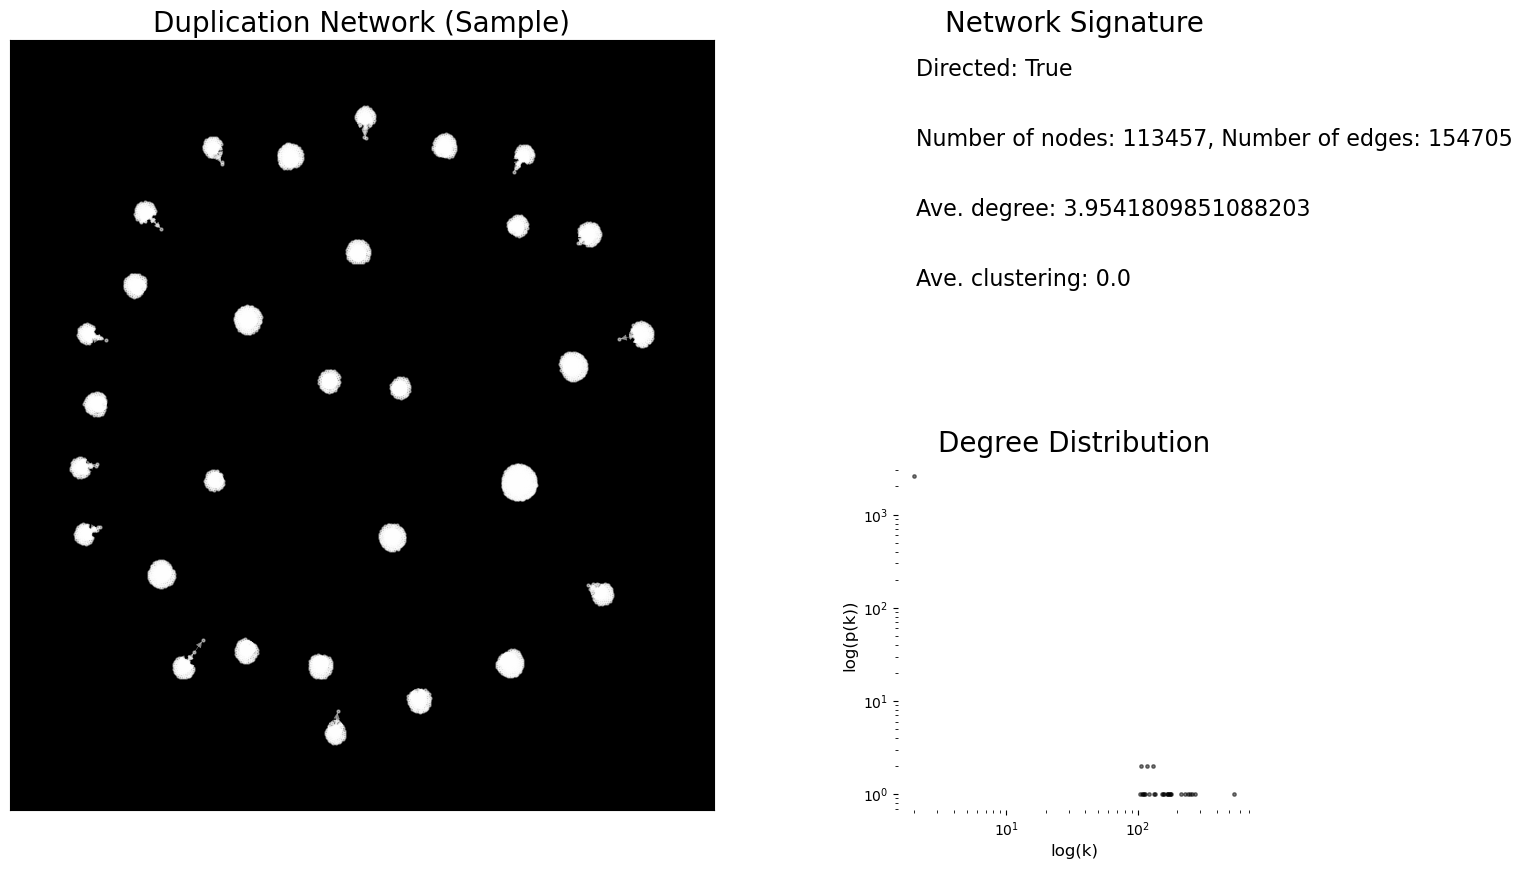

In [6]:
# Plot the subgraph
plot_subgraph(dup_g, title="Duplication Network (Sample)", num_of_nodes=30)

## 2.2 Dependency Network

23/07/17 23:41:43 WARN TaskSetManager: Stage 21 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


Number of nodes: 41964, Number of edges: 43397


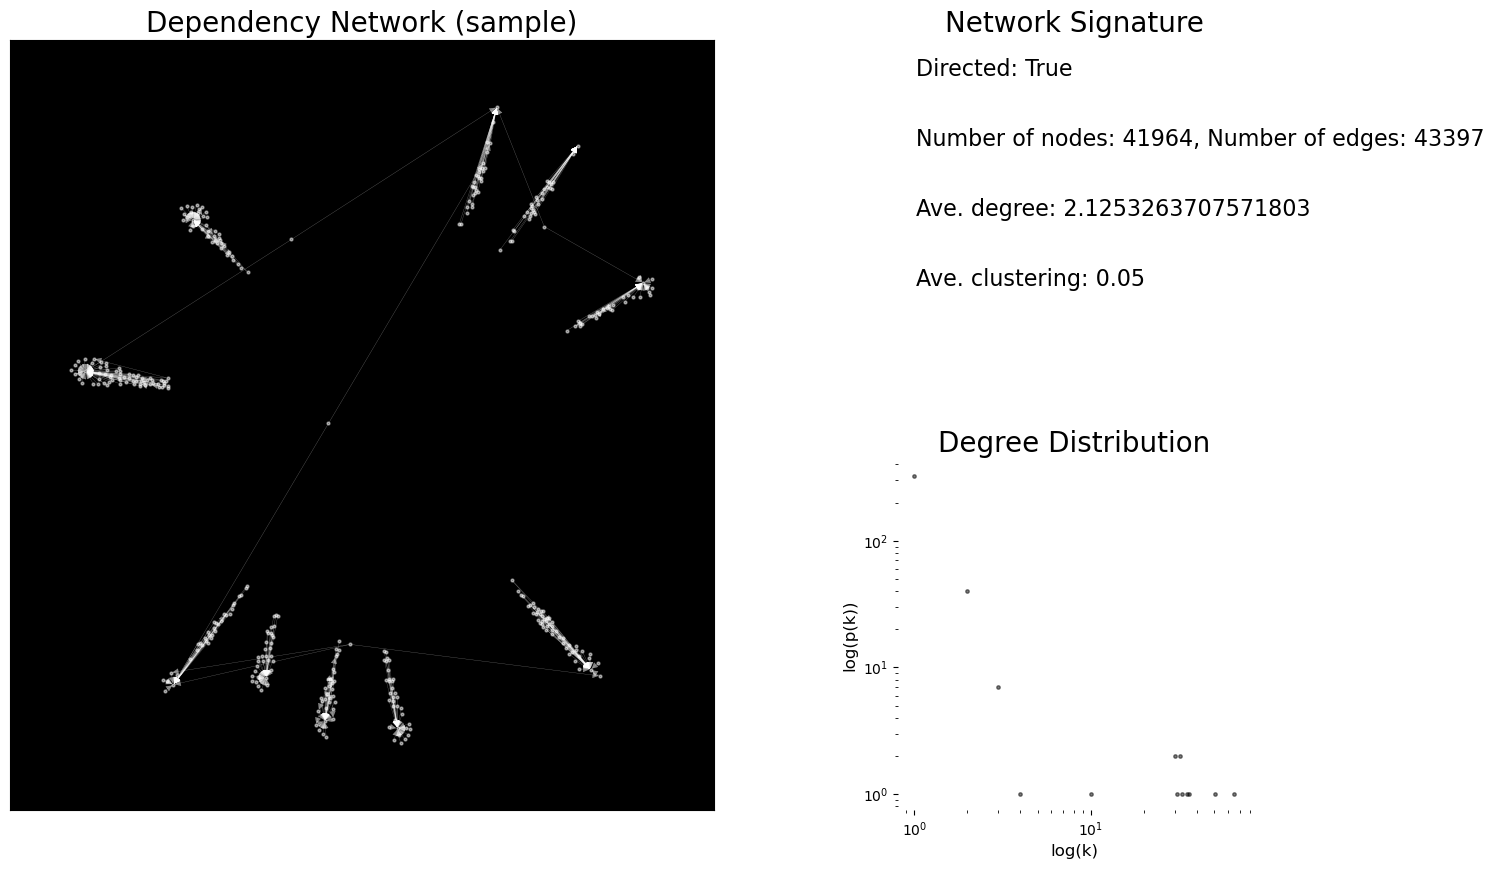

In [7]:
# The logic for the dependency network is similar to the duplication network
dep_g = nx.DiGraph()

dep_edges = bug_int_df.select(
    col("bug_id").alias("source"), col("depend_on").alias("target")
).distinct()

dep_edges_list = [
    ("bug_id:"+str(source), "bug_id:"+str(target_id))
    for source, target in dep_edges.collect()
    for target_id in target
]

dep_g.add_edges_from(dep_edges_list)
print(f'Number of nodes: {dep_g.number_of_nodes()}, Number of edges: {dep_g.number_of_edges()}')

plot_subgraph(dep_g, title='Dependency Network (sample)', num_of_nodes=10)

In [8]:
# Calculate the In-Degree Centrality
dep_in_degree = nx.in_degree_centrality(dep_g)
# dep_in_degree = dep_g.in_degree()
dep_in_degree_id = [int(bug_id.split(":")[1]) for bug_id in dep_in_degree.keys()]

# Create a dictionary of bug_id and in_degree
dep_in_degree = dict(zip(dep_in_degree_id, dep_in_degree.values()))

# Create a PySpark DataFrame from the dictionary
dep_in_degree_df = spark.createDataFrame(dep_in_degree.items(), ["bug_id", "dep_in_degree"])

# Merge the in_degree values with the bug_int_df DataFrame
bug_int_df = bug_int_df.join(dep_in_degree_df, on="bug_id", how="left")


## 2.3 Blocking Network

23/07/17 23:43:05 WARN TaskSetManager: Stage 24 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


Number of nodes: 37420, Number of edges: 38998


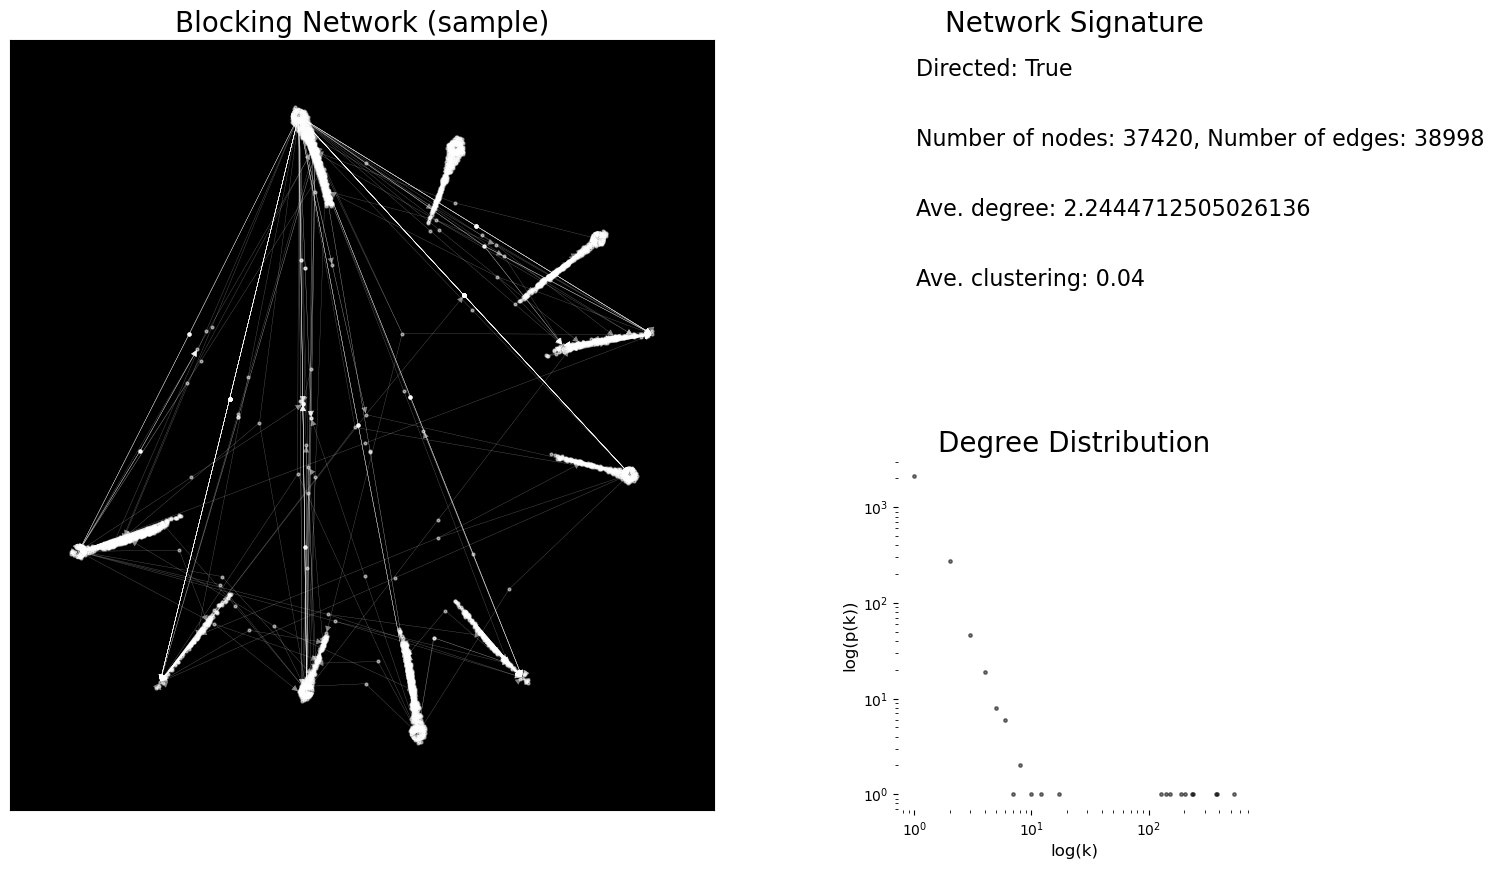

In [9]:
# Same
blocks_g = nx.DiGraph()

blocks_edges = bug_int_df.select(
    col("bug_id").alias("source"), col("blocks").alias("target")
).distinct()

blocks_edges_list = [
    ("bug_id:"+str(source), "bug_id:"+str(target_id))
    for source, target in blocks_edges.collect()
    for target_id in target
]

blocks_g.add_edges_from(blocks_edges_list)
print(f'Number of nodes: {blocks_g.number_of_nodes()}, Number of edges: {blocks_g.number_of_edges()}')

plot_subgraph(blocks_g, title='Blocking Network (sample)', num_of_nodes=10)

In [10]:
# Calculate the In-Degree Centrality
blocks_in_degree = nx.in_degree_centrality(blocks_g)
# blocks_in_degree = blocks_g.in_degree()
blocks_in_degree_id = [int(bug_id.split(":")[1]) for bug_id in blocks_in_degree.keys()]

# Create a dictionary of bug_id and in_degree
blocks_in_degree = dict(zip(blocks_in_degree_id, blocks_in_degree.values()))

# Create a PySpark DataFrame from the dictionary
blocks_in_degree_df = spark.createDataFrame(blocks_in_degree.items(), ["bug_id", "blocks_in_degree"])

# Merge the in_degree values with the bug_int_df DataFrame
bug_int_df = bug_int_df.join(blocks_in_degree_df, on="bug_id", how="left")

## 2.4 Caculate the resolution time of each bug

In [11]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType

# Filter the custom_fields DataFrame for the cf_last_resolved field
filtered_df = custom_fields.filter(F.col("cf_field_name") == "cf_last_resolved")
resolved_df = filtered_df.select("bug_id", "value").withColumnRenamed(
    "value", "resolved_time"
)
# Convert the value column to timestamp data type
resolved_df = filtered_df.withColumn(
    "resolved_time", F.col("value").cast(TimestampType())
)

# Select the necessary columns
resolved_df = resolved_df.select("bug_id", "resolved_time")
bug_int_df = bug_int_df.join(resolved_df, on="bug_id", how="right")
bug_int_df = bug_int_df.filter((F.col("status") == "VERIFIED") | (F.col("status") == "CLOSED"))

# Calculate the time difference between the creation and resolution of the bug
bug_int_df = bug_int_df.withColumn(
    "time_to_resolve",
    F.col("resolved_time") - F.col("creation_time").cast(TimestampType()),
)

# Convert the time_to_resolve column to days
bug_int_df = bug_int_df.withColumn(
    "time_to_resolve", F.col("time_to_resolve").cast("int") / (24 * 3600)
)


# Show the DataFrame
bug_int_df.show()

23/07/17 22:58:36 WARN TaskSetManager: Stage 21 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+------+---------------+-------------------+--------------------+-------+----------+--------+--------------------+--------------------+--------------------+-------------------+--------------------+
|bug_id|         blocks|      creation_time|           depend_on|dupe_of|duplicates|  status|       dup_in_degree|       dep_in_degree|    blocks_in_degree|      resolved_time|     time_to_resolve|
+------+---------------+-------------------+--------------------+-------+----------+--------+--------------------+--------------------+--------------------+-------------------+--------------------+
| 26486|             []|2000-02-04 01:48:17|                  []|      0|        []|VERIFIED|                null|                null|                null|2001-01-04 23:41:49|   335.9121759259259|
| 51056|             []|2000-09-01 16:50:47|                  []|      0|        []|VERIFIED|                null|                null|                null|2000-09-14 20:19:17|  13.144791666666666|
| 50124|  

In [12]:
bug_lr_df = bug_int_df.select(
    "bug_id",
    'dup_in_degree',
    'dep_in_degree',
    'blocks_in_degree',
    "time_to_resolve",
)
# Show the DataFrame
bug_lr_df.show()

23/07/17 22:58:38 WARN TaskSetManager: Stage 36 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+------+--------------------+--------------------+--------------------+--------------------+
|bug_id|       dup_in_degree|       dep_in_degree|    blocks_in_degree|     time_to_resolve|
+------+--------------------+--------------------+--------------------+--------------------+
| 26486|                null|                null|                null|   335.9121759259259|
| 51056|                null|                null|                null|  13.144791666666666|
| 50124|                null|                null|                null|   362.0605902777778|
|172267|8.813989564236357E-6|                null|                null| 0.16082175925925926|
| 52051|                null|                null|                null|   36.12960648148148|
|  1950|                null|                null|                null|  19.912280092592592|
| 39256|8.813989564236357E-6|                null|                null|   65.75600694444445|
| 81085|                null|4.766103472106379...|                 0.0

Now we run a linear regression to see if the centrality measures of the bugs are correlated with the resolution time of each bug.

In [13]:
from pyspark.ml.feature import VectorAssembler
# Create a list of columns to be used in the VectorAssembler
input_columns = [
    "dup_in_degree",
    "dep_in_degree",
    "blocks_in_degree",
]

# Create the VectorAssembler object
vec_assembler = VectorAssembler(inputCols=input_columns, outputCol="features")

# Transform the bug_int_df DataFrame
bug_lr_df = bug_lr_df.dropna()
bug_lr_df = vec_assembler.transform(bug_lr_df)

# Show the DataFrame
bug_lr_df.select("features").show(truncate=False)

# Import the necessary modules
from pyspark.ml.regression import LinearRegression

# Create a Linear Regression model object
lr = LinearRegression(featuresCol="features", labelCol="time_to_resolve")

# Fit the model to the data and call this model lrModel
lrModel = lr.fit(bug_lr_df)

# Print the coefficients and intercept for linear regression
print(
    "Coefficients: %s" % str(lrModel.coefficients),
    "Intercept: %s" % str(lrModel.intercept),
)

23/07/17 22:58:41 WARN TaskSetManager: Stage 51 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


+------------------------------------------------------------------+
|features                                                          |
+------------------------------------------------------------------+
|[8.813989564236357E-6,0.0,2.6724391351986957E-5]                  |
|[2.6441968692709068E-5,2.3830517360531898E-5,0.0]                 |
|[1.23395853899309E-4,0.0,2.6724391351986957E-5]                   |
|[8.813989564236357E-6,2.38305173605319E-4,0.0]                    |
|[8.813989564236357E-6,0.0,5.3448782703973914E-5]                  |
|[1.7627979128472713E-5,0.0,2.6724391351986957E-5]                 |
|[8.813989564236357E-6,0.0,2.6724391351986957E-5]                  |
|[2.6441968692709068E-5,2.3830517360531898E-5,0.0]                 |
|[3.5255958256945426E-5,2.3830517360531898E-5,0.0]                 |
|[8.813989564236357E-6,2.3830517360531898E-5,0.0]                  |
|[2.6441968692709068E-5,2.3830517360531898E-5,0.0]                 |
|[1.7627979128472713E-5,2.38305173

23/07/17 22:58:42 WARN TaskSetManager: Stage 66 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.
23/07/17 22:58:44 WARN TaskSetManager: Stage 79 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.
23/07/17 22:58:45 WARN Instrumentation: [c4e08a9b] regParam is zero, which might cause numerical instability and overfitting.
23/07/17 22:58:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/07/17 22:58:45 WARN TaskSetManager: Stage 94 contains a task of very large size (1053 KiB). The maximum recommended task size is 1000 KiB.


Coefficients: [585049.732835101,847602.3084113442,816972.881557544] Intercept: 204.3179019183493


In [14]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print(
    "numIterations: %d" % trainingSummary.totalIterations,
    "objectiveHistory: %s" % str(trainingSummary.objectiveHistory),
    "RMSE: %f" % trainingSummary.rootMeanSquaredError,
    "r2: %f" % trainingSummary.r2,
)

numIterations: 0 objectiveHistory: [0.0] RMSE: 501.100031 r2: 0.021199


# Part 3. Word2Vec with Pyspark

In [15]:
# Import the necessary modules
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import format_number as fmt

comments_sample = comments.sample(False, 0.1, 418)

comments_sample.show()

+-------+------+--------------------+-------------------+----------+-------------------+--------------------+--------------------+--------------------+-----+----+
|     id|bug_id|             creator|      creation_time|is_private|               time|              author|            raw_text|                text|count|tags|
+-------+------+--------------------+-------------------+----------+-------------------+--------------------+--------------------+--------------------+-----+----+
|1294666|138920| brant@gurganus.name|2002-04-21 04:56:13|     false|2002-04-21 04:56:13| brant@gurganus.name|From Bugzilla Hel...|From Bugzilla Hel...|    0|  []|
| 118513| 16258|morse@formerly-ne...|1999-10-15 20:14:59|     false|1999-10-15 20:14:59|morse@formerly-ne...|The behavior I am...|The behavior I am...|    4|  []|
| 118523| 16258|leger@formerly-ne...|1999-10-27 00:39:59|     false|1999-10-27 00:39:59|leger@formerly-ne...|dbaron, please do...|dbaron, please do...|   14|  []|
| 118527| 16258|   dba

## 3.1 Simple Tokenization with Stopwords Removal

In [16]:
# Tokenize text
tokenizer1 = RegexTokenizer(
    outputCol="DOC_TOKEN", inputCol="text", toLowercase=True, pattern="\\W"
)
comments_token = tokenizer1.transform(comments_sample)

remover = StopWordsRemover(inputCol="DOC_TOKEN", outputCol="DOC_STOP")
comments_token = remover.transform(comments_token)
comments_token.show()
# Learn a mapping from words to Vectors
word2Vec = Word2Vec(
    vectorSize=100, minCount=5, inputCol="DOC_STOP", outputCol="DOC_VECTOR"
)
model1 = word2Vec.fit(comments_token)

# Show the top 20 vectors
model1.getVectors().show(truncate=False)

# Find synonyms for the word "bug"
synonyms = model1.findSynonyms("bug", 20)

# Select the relevant columns and sort by similarity score
synonyms.select("word", fmt("similarity", 5).alias("similarity")).show()

In [17]:
# Print the results

synonyms.show(truncate=False)

+------+------------------+
|word  |similarity        |
+------+------------------+
|82534 |0.7552958726882935|
|120327|0.7518128156661987|
|120155|0.7438752055168152|
|28553 |0.7365292310714722|
|55690 |0.7262778282165527|
|56765 |0.7233074307441711|
|50633 |0.7232951521873474|
|51683 |0.7071123719215393|
|59108 |0.7054821848869324|
|53080 |0.7029532790184021|
|144027|0.7008401155471802|
|94035 |0.7002879977226257|
|111102|0.6989107728004456|
|56182 |0.6984217762947083|
|14026 |0.697482705116272 |
|84128 |0.6960240006446838|
|30431 |0.6938014030456543|
|47475 |0.6925617456436157|
|126224|0.6914102435112   |
|20618 |0.6908331513404846|
+------+------------------+



We can see in this case all the synonyms for bug are actually bug_ids. Although we can conclude that these bugs are discussed very frequently, we still would like to see how the programmers discuss about the bugs. Therefore, we need to update the tokenizer.

## 3.2 Remove the `bug_ids` from the Tokenizer

In [18]:
# Tokenizer to remove punctuation and numbers
tokenizer2 = RegexTokenizer(
    outputCol="DOC_TOKEN",
    inputCol="text",
    toLowercase=True,
    pattern="[^A-Za-z]+",
    gaps=True,
)
comments_token = tokenizer2.transform(comments_sample)

# Remove stop words
remover = StopWordsRemover(inputCol="DOC_TOKEN", outputCol="DOC_STOP")
comments_token = remover.transform(comments_token)
comments_token.select("bug_id", "DOC_STOP").show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bug_id|DOC_STOP                                                                                                                                                                                                                                                     

In [19]:

# Learn a mapping from words to Vectors
word2Vec = Word2Vec(
    vectorSize=100, minCount=5, inputCol="DOC_STOP", outputCol="DOC_VECTOR"
)

# Fit the model to the data
model2 = word2Vec.fit(comments_token)

# Find synonyms for the word "bug"
synonyms = model2.findSynonyms("bug", 20)

# Select the relevant columns and sort by similarity score
synonyms.select("word", fmt("similarity", 5).alias("similarity")).show()

# Print the results
synonyms.show(truncate=False)


+----------+----------+
|      word|similarity|
+----------+----------+
|    duping|   0.71514|
|   dupping|   0.64764|
|    undupe|   0.60049|
|duplicates|   0.59256|
|     duped|   0.59194|
| wontfixed|   0.57884|
|discretion|   0.56049|
|   falsely|   0.54820|
|      yawn|   0.54520|
| reclosing|   0.54113|
|     koike|   0.54001|
|     dupes|   0.53501|
|    voters|   0.53454|
|      dups|   0.53381|
|      amen|   0.53103|
|     morph|   0.52924|
|     filed|   0.52630|
|      bleh|   0.52385|
|    hsinyi|   0.52120|
|     wasnt|   0.51448|
+----------+----------+

+----------+------------------+
|word      |similarity        |
+----------+------------------+
|duping    |0.7151402831077576|
|dupping   |0.6476350426673889|
|undupe    |0.6004914045333862|
|duplicates|0.5925578474998474|
|duped     |0.5919380187988281|
|wontfixed |0.5788434743881226|
|discretion|0.560485303401947 |
|falsely   |0.5481956601142883|
|yawn      |0.5451980233192444|
|reclosing |0.5411293506622314|
|koike 

Seems better. But we can still improve.

## 3.3 Spacy Tokenizer

In [20]:
import spacy
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Load the spacy model: nlp
nlp = spacy.load("en_core_web_sm")

# Define the tokenizer function
def tokenizer(text):
    # Create a Doc object
    doc = nlp(text)
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [
        lemma
        for lemma in lemmas
        if lemma.isalpha() and lemma not in nlp.Defaults.stop_words
    ]
    return a_lemmas


# Create the user defined function
lemmatizer = udf(lambda x: tokenizer(x), ArrayType(StringType()))

# Create a new tokens column for the cleaned text
comments_token = comments_sample.withColumn("DOC_STOP", lemmatizer("text"))

# Show the DataFrame
comments_token.select("bug_id", "DOC_STOP").show(truncate=False)


+------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|bug_id|DOC_STOP                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [21]:
# Learn a mapping from words to Vectors
word2Vec = Word2Vec(
    vectorSize=100,
    minCount=5,
    inputCol="DOC_STOP",
    outputCol="DOC_VECTOR",
    windowSize=2,
    seed=418,
)

# Fit the model to the data
model3 = word2Vec.fit(comments_token)

# Find synonyms for the word "bug"
synonyms = model3.findSynonyms("bug", 20)

# Select the relevant columns and sort by similarity score
synonyms.select("word", fmt("similarity", 5).alias("similarity")).show()

# Print the results
synonyms.show(truncate=False)

+------------+----------+
|        word|similarity|
+------------+----------+
|     wontfix|   0.69268|
|      future|   0.65739|
|        vrfy|   0.65246|
|         dup|   0.64211|
|verification|   0.63122|
|       pchen|   0.62495|
|       fixed|   0.62312|
|      verify|   0.61658|
|     invalid|   0.61324|
|    VERIFIED|   0.61299|
|    disagree|   0.61128|
|        dupe|   0.59035|
|        lack|   0.58492|
|    Verified|   0.57685|
|     reoccur|   0.57624|
|    verified|   0.56745|
|      reopen|   0.56390|
|         XIE|   0.56124|
|         DUP|   0.56081|
|        Eric|   0.56025|
+------------+----------+
+------------+------------------+
|word        |similarity        |
+------------+------------------+
|wontfix     |0.6926802396774292|
|future      |0.6573892831802368|
|vrfy        |0.6524646282196045|
|dup         |0.6421114802360535|
|verification|0.631224513053894 |
|pchen       |0.6249496936798096|
|fixed       |0.6231184005737305|
|verify      |0.6165834069252014|
|i